# Рекомендация тарифов

## Изучение датасета

In [1]:
import pandas as pd
from warnings import simplefilter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
simplefilter(action='ignore', category=FutureWarning)
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


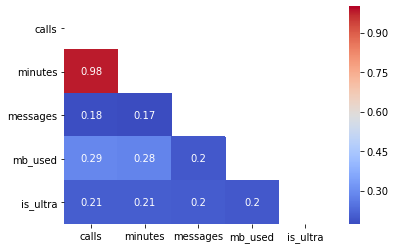

In [4]:
#собираюсь посмотреть мультиколлинеарность факторов
matrix = np.triu(df.corr())
hm = sns.heatmap(df.corr(),cbar=True,annot=True,cmap= 'coolwarm',mask=matrix)

***Насколько я понял именно колличесвто минут использованных абонентами больше всего коррелируется с нашим таргетом***

## Разбиение данных на выборки

In [5]:
#разобью данные на выборки
df_train, df_temp = train_test_split(df, train_size=0.6,random_state=12345)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=12345)
# создам переменные для признаков и целевого признака
#валидационный набор данных
features_valid = df_valid.drop(['is_ultra'], axis=1) 
target_valid = df_valid['is_ultra']
#обучающий набор данных
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
#тестовый набор данных
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra'] 


## Исследование моделей

- Собираюсь исследовать модель 'Решающее дерево'

In [6]:
model_Tree = DecisionTreeClassifier(random_state=12345)
model_Tree.fit(features_train,target_train)
predict_Tree = model_Tree.predict(features_train)
predict_Tree_valid = model_Tree.predict(features_valid)
predict_Tree_accuracy = accuracy_score(target_train,predict_Tree)
predict_Tree_valid_accuracy = accuracy_score(target_valid,predict_Tree_valid)
print("Accuracy model_Tree")
print("Обучающая выборка:",predict_Tree_accuracy)
print("Валидационная выборка:",predict_Tree_valid_accuracy)

Accuracy model_Tree
Обучающая выборка: 1.0
Валидационная выборка: 0.713841368584759


***Сейчас точность предсказаний модели составляет 71%.Постараюсь улучшить модель и найти подходящие гиперпараметры***

In [7]:
#хочу узнать глубину изучения для модели чтобы улучшить ее
for depth in range(1,5):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.7542768273716952
max_depth = 2 : 0.7822706065318819
max_depth = 3 : 0.7853810264385692
max_depth = 4 : 0.7791601866251944


***Проверю точность модели установив параметр depth = 3,поскольку именно такая модель показывает лучшие результаты***

In [8]:
model_Tree = DecisionTreeClassifier(random_state=12345,max_depth=3)
model_Tree.fit(features_train,target_train)
predict_Tree = model_Tree.predict(features_train)
predict_Tree_valid = model_Tree.predict(features_valid)
predict_Tree_accuracy = accuracy_score(target_train,predict_Tree)
predict_Tree_valid_accuracy = accuracy_score(target_valid,predict_Tree_valid)

print("Accuracy model_Tree")
print("Обучающая выборка:",predict_Tree_accuracy)
print("Валидационная выборка:",predict_Tree_valid_accuracy)

Accuracy model_Tree
Обучающая выборка: 0.8075726141078838
Валидационная выборка: 0.7853810264385692


***Модель стала показывать результат дучше на целых 7%,но при этом точность обучающей модели снизилась,не совсем понимаю почему***

- Собираюсь исследовать модель 'cлучайный лес'

In [9]:
model_Forest = RandomForestClassifier(random_state=12345)
model_Forest.fit(features_train,target_train)

predict_model_Forest = model_Forest.predict(features_train)
predict_model_Forest_valid = model_Forest.predict(features_valid)
predict_model_Forest_accuracy = accuracy_score(target_train,predict_model_Forest)
predict_model_Forest_valid_accuracy = accuracy_score(target_valid,predict_model_Forest_valid)
print("Accuracy model_Forest")
print("Обучающая выборка:",predict_model_Forest_accuracy)
print("Валидационная выборка:",predict_model_Forest_valid_accuracy)

Accuracy model_Forest
Обучающая выборка: 0.9823651452282157
Валидационная выборка: 0.7853810264385692


***Показатели модели по обучающей выборке лучше чем у предидущей,постараюсь улучшить и эту модель и найти лучшие параметры для нее***

In [10]:
#находим лучшие параметры для модели случайного леса
best_model = None
best_result = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train) 
    result = model.score(features_valid,target_valid) 
    if result > best_result:
        best_model = model 
        best_result = result
        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print(best_model)

Accuracy наилучшей модели на валидационной выборке: 0.7853810264385692
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


***Тут я специально оставил вывод лучшей модели чтобы посмотреть параметр n_estimators=10***

In [11]:
for depth in range(1,10):
    model = RandomForestClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

max_depth = 1 : 0.7558320373250389
max_depth = 2 : 0.7776049766718507
max_depth = 3 : 0.7853810264385692
max_depth = 4 : 0.7900466562986003
max_depth = 5 : 0.7931570762052877
max_depth = 6 : 0.8009331259720062
max_depth = 7 : 0.7947122861586314
max_depth = 8 : 0.7962674961119751
max_depth = 9 : 0.7853810264385692


***При глубине max_depth = 6 модель показывает лучшие результаты на валидационной выборке***

In [12]:
model_Forest = RandomForestClassifier(random_state=12345,max_depth=6,n_estimators=10)
model_Forest.fit(features_train,target_train)

predict_model_Forest = model_Forest.predict(features_train)
predict_model_Forest_valid = model_Forest.predict(features_valid)
predict_model_Forest_accuracy = accuracy_score(target_train,predict_model_Forest)
predict_model_Forest_valid_accuracy = accuracy_score(target_valid,predict_model_Forest_valid)
print("Accuracy model_Forest")
print("Обучающая выборка:",predict_model_Forest_accuracy)
print("Валидационная выборка:",predict_model_Forest_valid_accuracy)

Accuracy model_Forest
Обучающая выборка: 0.8350622406639004
Валидационная выборка: 0.8009331259720062


***Я добился точности модели в 80%,насколько я знаю такая модель будет очень медленная***

- Собираюсь изучить модель 'Логистической регрессии'

In [13]:
model_Regression = LogisticRegression(random_state=12345)
model_Regression.fit(features_train,target_train)
predict_model_Regression = model_Regression.predict(features_train)
predict_model_Regression_valid = model_Regression.predict(features_valid)
predict_model_Regression_accuracy = accuracy_score(target_train,predict_model_Regression)
predict_model_Regression_valid_accuracy = accuracy_score(target_valid,predict_model_Regression_valid)
print("Accuracy model_Regression")
print("Обучающая выборка:",predict_model_Regression_accuracy)
print("Валидационная выборка:",predict_model_Regression_valid_accuracy)

Accuracy model_Regression
Обучающая выборка: 0.7505186721991701
Валидационная выборка: 0.7589424572317263


## Проверка моделей на тестовой выборке

In [14]:
#теперь проверим модели на тестовой выборке
predict_Tree = model_Tree.predict(features_test)
predict_Tree_accuracy = accuracy_score(target_test,predict_Tree)

predict_model_Forest =model_Forest.predict(features_test)
accuracy_model_Forest = accuracy_score(target_test,predict_model_Forest)

predict_model_Regression = model_Regression.predict(features_test)
accuracy_model_Regression = accuracy_score(target_test,predict_model_Regression)

print('Accuracy модели "решающее дерево":',predict_Tree_accuracy)
print('Accuracy модели "случайный лес":',accuracy_model_Forest)
print('Accuracy модели "логистическая регрессия":',accuracy_model_Regression)

Accuracy модели "решающее дерево": 0.7791601866251944
Accuracy модели "случайный лес": 0.7916018662519441
Accuracy модели "логистическая регрессия": 0.7402799377916018


***Лучшие показатели у моделей решающее дерево и случайный лес поэтому я выбираю их***

##  Проверка моделей на адекватность

In [15]:
#проверю соотношение тарифов
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [16]:
306472 / 693528

0.4419028503535546

***Тарифов Smart в выборке на 44% больше чем тарифа Ultra.Проверю модели на всей выборке но при этом уберу значения тарифа Smart и посмотрю как модели предсказывают тариф Ultra*** 

In [17]:
ultra_features = df.query('is_ultra == 1').drop(['is_ultra'], axis=1)
ultra_target = df.query('is_ultra == 1')['is_ultra']

predict_Tree = model_Tree.predict(ultra_features)
predict_Tree_accuracy = accuracy_score(ultra_target,predict_Tree)

predict_model_Forest =model_Forest.predict(ultra_features)
accuracy_model_Forest = accuracy_score(ultra_target,predict_model_Forest)

print('Accuracy модели "решающее дерево":',predict_Tree_accuracy)
print('Accuracy модели "случайный лес":',accuracy_model_Forest)

Accuracy модели "решающее дерево": 0.4730964467005076
Accuracy модели "случайный лес": 0.5116751269035533


***Теперь сделаю тоже самое для тарифа Smart***

In [18]:
smart_features = df.query('is_ultra == 0').drop(['is_ultra'], axis=1)
smart_target = df.query('is_ultra == 0')['is_ultra']

predict_Tree = model_Tree.predict(smart_features)
predict_Tree_accuracy = accuracy_score(smart_target,predict_Tree)

predict_model_Forest =model_Forest.predict(smart_features)
accuracy_model_Forest = accuracy_score(smart_target,predict_model_Forest)

print('Accuracy модели "решающее дерево":',predict_Tree_accuracy)
print('Accuracy модели "случайный лес":',accuracy_model_Forest)

Accuracy модели "решающее дерево": 0.9407806191117093
Accuracy модели "случайный лес": 0.955585464333782


***Как я и предполагал тариф Smart модели предсказывают с намного большей точностью***

## Вывод

Я построил 3 модели:

- Решающее дерево
- Случайный лес
- Модель Регрессии

Лучшие результаты на тестовой выборке показали модели Решающее дерево и Случайный лес,они набрали 77% и 79% соответственно.В модели регрессии мне неудалось достичь показателей превышающих 95% accuracy.
Но при этом из-за неравномерности данных итоговые модели лучше предсказывают тариф Smart.